<a href="https://colab.research.google.com/github/TomHSYu/DSTutorials/blob/main/TTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Author: [Tom (Hyeon Seok) Yu](https://tomhsyu.com/)
*   Last Update: 11/26/2023
*   Purpose: Implementation guide for top-two Thompson Sampling algorithm and its performance comparison.
*   Corresponding Post: https://tomhsyu.com/article%20review/technical%20guide/python/TTTS/

In [ ]:
## Import packages and data
import numpy as np
import pandas as pd
import scipy.stats as stats
import sys
import copy
import matplotlib.pyplot as plt
from collections import Counter

data_dir = "https://github.com/TomHSYu/DSTutorials/blob/main/Data/SDC_Cleaned.csv?raw=true"
df = pd.read_csv(data_dir)

## Data Preparation

In [ ]:
## Compute mean and SDs of each treatment group
# Conver the outcome for the ease of interpretation and discretize it for the bernoulli bandit
df['PA_outcome'] = 100 - df['PA1']
df['PA_flag'] = (df['PA_outcome'] >= 40).astype(int)  # adjust the threshold as necessary

# Set intervention list name
interventions = ['Democratic_Fear', 'Empathy_Beliefs', 'Economic_Interests', 'Civity_Storytelling',
                 'Counterfactual_Selves', 'Common_Identity', 'Partisan_Threat',
                 'Moral_Differences', 'System_Justification', 'Misperception_Film', 'Utah_Cues',
                 'Party_Overlap', 'Violence_Efficacy', 'Contact_Project', 'Learning_Goals',
                 'Media_Trust', 'Befriending_Meditation', 'Outparty_Friendship',
                 'Misperception_Competition', 'Harmful_Experiences', 'Misperception_Suffering',
                 'Chatbot_Quiz', 'Epistemic_Rescue', 'Inparty_Elites', 'Misperception_Democratic']

# Obtain the mean value (truth) of each intervention
est_df = []
for i in range(len(interventions)):
  temp_df = df.loc[(df[interventions[i]] == 1)]
  temp_lst = [interventions[i], temp_df.PA_flag.mean(), temp_df.PA_flag.std()]
  est_df.append(temp_lst)
est_df = pd.DataFrame(est_df)
est_df.columns = ['Intervention', 'Mean', 'SD']
print(est_df)

                 Intervention      Mean        SD
0             Democratic_Fear  0.427313  0.494906
1             Empathy_Beliefs  0.427568  0.494943
2          Economic_Interests  0.348940  0.476846
3         Civity_Storytelling  0.478836  0.499772
4       Counterfactual_Selves  0.422771  0.494218
5             Common_Identity  0.565674  0.495885
6             Partisan_Threat  0.335979  0.472540
7           Moral_Differences  0.426937  0.494851
8        System_Justification  0.412281  0.492461
9          Misperception_Film  0.529568  0.499345
10                  Utah_Cues  0.419721  0.493729
11              Party_Overlap  0.413158  0.492617
12          Violence_Efficacy  0.328332  0.469814
13            Contact_Project  0.485615  0.500011
14             Learning_Goals  0.385362  0.486895
15                Media_Trust  0.538462  0.498737
16     Befriending_Meditation  0.401582  0.490434
17        Outparty_Friendship  0.431579  0.495514
18  Misperception_Competition  0.439261  0.496516


In [ ]:
## Define three sets of data representing different scenarios

# Clear winner
clear_winner = [5, 0, 1, 4, 7, 8, 10, 11, 16, 17]
true_means_cw = est_df.iloc[clear_winner].Mean.values.tolist()
true_bai_cw = np.argmax(true_means_cw)  # the index of the true best arm = 0

# No clear winner
no_clear_winner = [0, 1, 4, 7, 8, 10, 11, 16, 17, 18]
true_means_ncw = est_df.iloc[no_clear_winner].Mean.values.tolist()
true_bai_ncw = np.argmax(true_means_ncw)  # the index of the true best arm = 9

# Competing second-best
compete_second_best = [9, 15, 0, 1, 4, 7, 8, 10, 11, 16]
true_means_csb = est_df.iloc[compete_second_best].Mean.values.tolist()
true_bai_csb = np.argmax(true_means_csb)

data_means = [true_means_cw, true_means_ncw, true_means_csb]
true_bais = [true_bai_cw, true_bai_ncw, true_bai_csb]

In [ ]:
## Utility functions
def print_progress_bar(index, total, label):
    n_bar = 50  # Progress bar width
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

def plot_treat_assignment(assign_list, exp_ind):
    """
    Generate a plot of treatment assignment history for a single experiment

    Input:
        - assign_list: list that contains treatment assignment history list for each experiment
        - exp_ind: an experiment index to plot
    Output:
        - plot
    """
    plot_df = pd.DataFrame(assign_list[exp_ind])
    plot_df.columns = ['treat']
    plot_df['ind'] = plot_df.index
    plot_df['cum_count'] = plot_df.groupby([plot_df.treat]).cumcount() + 1
    plot_df['TreatGroup'] = plot_df['treat'] + 1
    plot_df['TreatGroup'] = 'Treat' + plot_df['TreatGroup'].astype(str)
    fig, ax = plt.subplots()

    i = 0
    for name, group in plot_df.groupby('TreatGroup'):
      group.plot(x = 'ind', y = 'cum_count', ax = ax, label = name)
      i += 1

## Baseline: Uniform Randomization

In [ ]:
class UniformRandom:
  def __init__(self, m):
    self.m = m
    self.n = 0
    self.r = []       # list of rewards
    self.s = 1        # success count
    self.f = 1        # failure count

  def pull(self):
    ''' return a value using the true mean and variance for the arm '''
    return np.random.binomial(n=1, p=self.m)

  def update(self, r):
    self.n += 1
    self.s += r
    self.f += (1-r)
    self.r.append(r)

  def sample(self, num_size=None):
    return np.random.beta(self.s, self.f, size=num_size)

def post_probs(arms, num_mc):
  """
  Return the posterior probability of being the best arm based on MC

  INPUT:
      - arms: uniform randomization class objects
      - num_mc: number of Monte Carlo simulations to calculate poterior probability

  OUTPUT:
      - probs: poterior probability computed by Thompson sampling

  """
  K = len(arms)
  arm_samples = [arm.sample(num_size = num_mc) for arm in arms]
  idx = np.argmax(arm_samples, axis = 0)
  w_mc = np.array([np.sum(idx == k) for k in range(K)])
  return w_mc / num_mc

In [ ]:
def UniformRandomSim(conf_levels, true_vals, true_best_arm_ind):

  treat_assignment_list = []
  arms = [ UniformRandom(m) for m in true_vals]
  K = len(arms)
  sim_size = 0
  sim_size_list = []
  best_arm_ind = np.nan
  temp_conf_levels = copy.deepcopy(conf_levels)

  while len(temp_conf_levels) > 0:

    # Random assignment
    temp_assignment = np.random.randint(low = 0, high = len(arms))
    treat_assignment_list.append(temp_assignment)
    temp_resp = [0] * len(arms)
    temp_resp[temp_assignment] = 1

    # Obtain the reward value based on this treatment assignment and update the arm posterior
    reward = arms[temp_assignment].pull()
    arms[temp_assignment].update(reward)

    # Compute posterior probs of each arm being best based on MC
    temp_probs = post_probs(arms, num_mc=100)

    # Check whether the desired confidence level has been reached and save the best arm indicator
    best_arm_ind = np.argmax(temp_probs)

    if temp_probs[best_arm_ind] > temp_conf_levels[0]:
      sim_size_list.append(sim_size)
      temp_conf_levels.pop(0)
    sim_size += 1

  # Indicator for whether the correct best arm has been identified
  if best_arm_ind == true_best_arm_ind:
    correct_ind = 1
  else:
    correct_ind = 0
  return(sim_size_list + [correct_ind], treat_assignment_list)

## Thompson Sampling

In [ ]:
## Define the bernoulli bandit and corresponding functions for adaptively re-weighted AIPW estimator
class BernThompson:
  def __init__(self, m):
    self.m = m
    self.n = 0
    self.r = []       # list of rewards
    self.s = 1        # success count
    self.f = 1        # failure count

  def pull(self):
    return np.random.binomial(n=1, p=self.m)

  def update(self, r):
    self.n += 1
    self.s += r
    self.f += (1-r)
    self.r.append(r)

  def sample(self, num_size=None):
    return np.random.beta(self.s, self.f, size=num_size)

In [ ]:
## Define the simulation function
def BernThompsonSim(conf_levels, true_vals, true_best_arm_ind):
  treat_assignment = []
  arms = [ BernThompson(m) for m in true_vals]
  K = len(arms)
  sim_size_list = []
  sim_size = 0
  best_arm_ind = np.nan
  temp_conf_levels = copy.deepcopy(conf_levels)

  while len(temp_conf_levels) > 0:
    # Warm up: uniform randomization for the first 250 obs. (10 per treatment)
    if (sim_size < 250):
      temp_assignment = np.random.randint(low = 0, high = K)
      treat_assignment.append(temp_assignment)
      reward = arms[temp_assignment].pull()
      arms[temp_assignment].update(reward)

    else:
      # Draw a sample from each arm
      arm_samples = [arm.sample() for arm in arms]

      # Treatment assignment, update the posterior and check whether the confidence level is met
      temp_assignment = np.argmax(arm_samples)
      reward = arms[temp_assignment].pull()
      arms[temp_assignment].update(reward)
      treat_assignment.append(temp_assignment)
      temp_probs = post_probs(arms, num_mc=100)

      # Check whether the desired confidence level has been reached and save the best arm indicator
      best_arm_ind = np.argmax(temp_probs)
      if temp_probs[best_arm_ind] > temp_conf_levels[0]:
        sim_size_list.append(sim_size)
        temp_conf_levels.pop(0)
    sim_size += 1

  # Indicator: correct identification of the true best arm
  if best_arm_ind == true_best_arm_ind:
    correct_ind = 1
  else:
    correct_ind = 0

  return (sim_size_list + [correct_ind], treat_assignment)

## Top-Two Thompson Sampling

In [ ]:
## Define the simulation function
def BernTTThompsonSim(conf_levels, true_vals, true_best_arm_ind):
  treat_assignment = []
  arms = [ BernThompson(m) for m in true_vals]
  K = len(arms)
  sim_size_list = []
  sim_size = 0
  best_arm_ind = np.nan
  temp_conf_levels = copy.deepcopy(conf_levels)

  while len(temp_conf_levels) > 0:
    # Warm up: uniform randomization for the first 250 obs. (10 per treatment)
    if (sim_size < 250):
      temp_assignment = np.random.randint(low = 0, high = K)
      treat_assignment.append(temp_assignment)
      reward = arms[temp_assignment].pull()
      arms[temp_assignment].update(reward)

    else:
      # Draw a sample from each arm
      arm_samples = [arm.sample() for arm in arms]

      # Treatment(I) assignment (Thompson Sampling)
      temp_assignment_i = np.argmax(arm_samples)

      # Treatment(J) assignment (Top-Two Resampling)
      temp_b = np.random.binomial(n=1, p=1/2)
      if temp_b == 1:
        temp_assignment = temp_assignment_i
      else:
        temp_assignment_j = temp_assignment_i
        while temp_assignment_j == temp_assignment_i:
          new_arm_samples = [arm.sample() for arm in arms]
          temp_assignment_j = np.argmax(new_arm_samples)
        temp_assignment = temp_assignment_j

      reward = arms[temp_assignment].pull()
      arms[temp_assignment].update(reward)
      treat_assignment.append(temp_assignment)
      temp_probs = post_probs(arms, num_mc=100)

      # Check whether the desired confidence level has been reached and save the best arm indicator
      best_arm_ind = np.argmax(temp_probs)
      if temp_probs[best_arm_ind] > temp_conf_levels[0]:
        sim_size_list.append(sim_size)
        temp_conf_levels.pop(0)

    sim_size += 1

  # Indicator: correct identification of the true best arm
  if best_arm_ind == true_best_arm_ind:
    correct_ind = 1
  else:
    correct_ind = 0

  return (sim_size_list + [correct_ind], treat_assignment)

## Comparing Results:

In [ ]:
# Experiment execution function
def run_experiment(alg, B, conf_levels, true_means, true_best_arm_ind, sample_ind):
  sample_size_lists = []
  treat_assignment_lists = []
  i = 0
  while i < B:
    if alg == "UR":
      temp_res1, temp_res2 = UniformRandomSim(conf_levels=conf_levels, true_vals=true_means,
                            true_best_arm_ind=true_best_arm_ind)
    elif alg == "TS":
      temp_res1, temp_res2 = BernThompsonSim(conf_levels=conf_levels, true_vals=true_means,
                            true_best_arm_ind=true_best_arm_ind)
    elif alg == "TTTS":
      temp_res1, temp_res2 = BernTTThompsonSim(conf_levels=conf_levels, true_vals=true_means,
                            true_best_arm_ind=true_best_arm_ind)
    sample_size_lists.append(temp_res1)
    treat_assignment_lists.append(temp_res2)
    print_progress_bar(i, B, "Progress")
    i += 1

  conf_names = []
  for conf in conf_levels:
    conf_names.append('Conf_'+str(conf * 100))
  headers = conf_names + ['CorrectID']
  eval_df = pd.DataFrame(sample_size_lists, columns = headers)
  # print(eval_df.mean().round(3))

  # Average sample size by treatment group
  temp_df_list = []
  for i in range(len(treat_assignment_lists)):
    temp_df_list.append(Counter(treat_assignment_lists[i]))
  sample_df = pd.DataFrame(temp_df_list)
  print("\n")
  print(sample_df.mean(axis=0))

  # Sample plot of treament assignment over time (single experiment)
  plot_treat_assignment(treat_assignment_lists, sample_ind)
  plt.show()
  print(Counter(treat_assignment_lists[sample_ind]))

  return(eval_df)

[================================================= ] 99%  Progress

6    221.27
9    221.43
2    222.28
0    224.15
1    221.68
3    223.87
4    220.27
8    223.37
5    224.35
7    223.27
dtype: float64


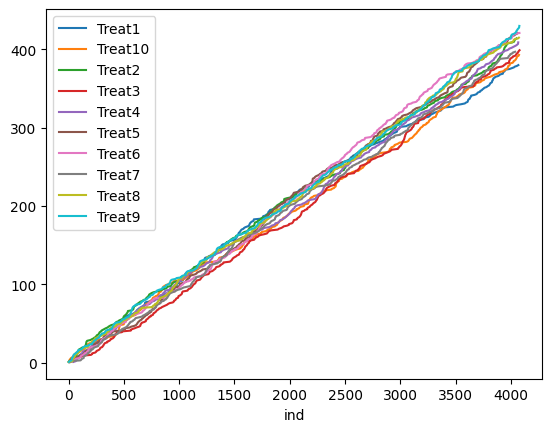

Counter({8: 430, 5: 421, 4: 421, 7: 415, 1: 414, 3: 409, 2: 399, 6: 397, 9: 393, 0: 380})
[================================================= ] 99%  Progress

7      72.00
8      71.21
1     101.33
2      85.79
9      98.88
3      90.95
6      80.52
5      72.55
0    1553.92
4      84.50
dtype: float64


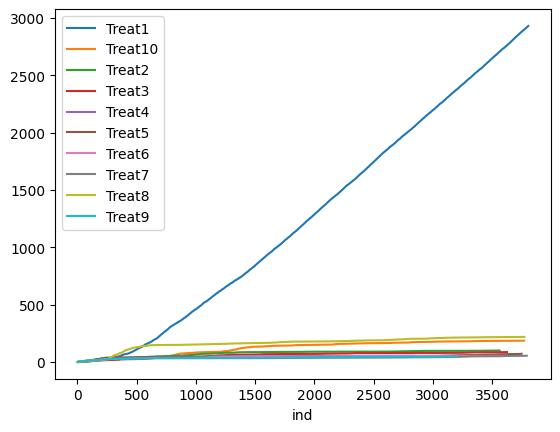

Counter({0: 2929, 7: 219, 9: 187, 1: 100, 2: 87, 4: 72, 6: 55, 5: 54, 3: 54, 8: 49})
[================================================= ] 99%  Progress

5     91.41
7     88.43
4    107.03
8     68.92
3     88.02
1    102.99
9    112.84
0    451.81
2     93.10
6     87.92
dtype: float64


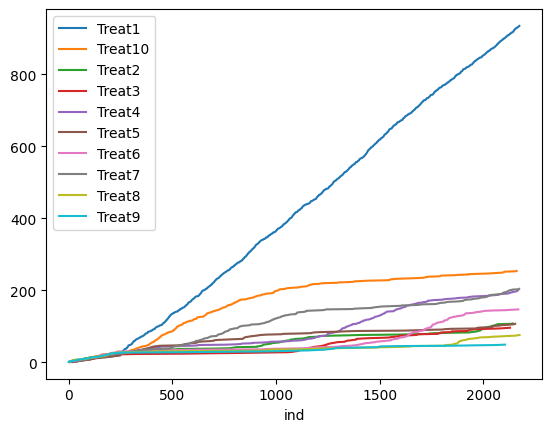

Counter({0: 935, 9: 254, 6: 204, 3: 200, 5: 147, 1: 108, 4: 107, 2: 96, 7: 76, 8: 49})
[================================================= ] 99%  Progress

6    19016.27
3    19028.49
5    19022.13
9    19018.07
7    19018.14
4    19003.86
2    19015.50
0    19025.23
8    19028.06
1    19018.03
dtype: float64


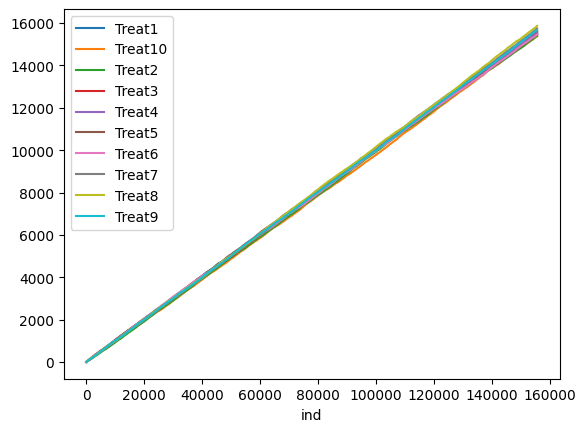

Counter({7: 15866, 6: 15745, 8: 15662, 2: 15630, 0: 15536, 3: 15532, 4: 15468, 5: 15466, 1: 15395, 9: 15378})
[================================================= ] 99%  Progress

0      9585.80
3      8943.04
7      1323.92
1      9787.51
5      3977.41
8     21356.72
2      6075.06
4      2616.72
9    106690.28
6      2577.37
dtype: float64


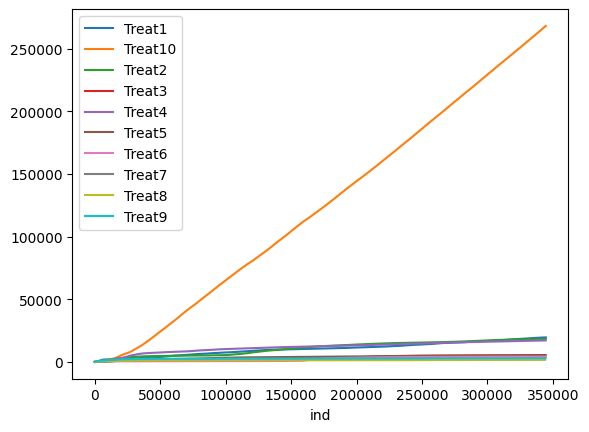

Counter({9: 268054, 0: 19556, 1: 18394, 3: 17132, 2: 5508, 4: 5063, 5: 4212, 8: 3012, 6: 1952, 7: 1769})
[================================================= ] 99%  Progress

0     8140.10
9    39943.31
4     2756.13
7     1380.88
6     2780.96
8    23547.88
1    12895.95
2     5751.33
3     9223.72
5     4799.55
dtype: float64


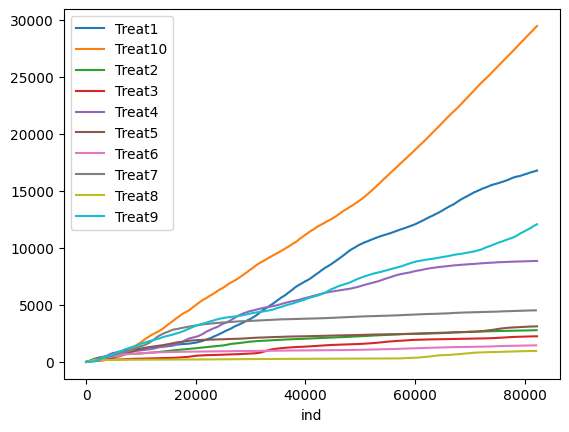

Counter({9: 29451, 0: 16775, 8: 12069, 3: 8854, 6: 4522, 4: 3119, 1: 2786, 2: 2248, 5: 1453, 7: 963})
[================================================= ] 99%  Progress

6    5858.68
3    5850.95
1    5854.83
2    5842.17
4    5864.63
0    5854.97
9    5855.49
8    5852.58
7    5836.99
5    5853.71
dtype: float64


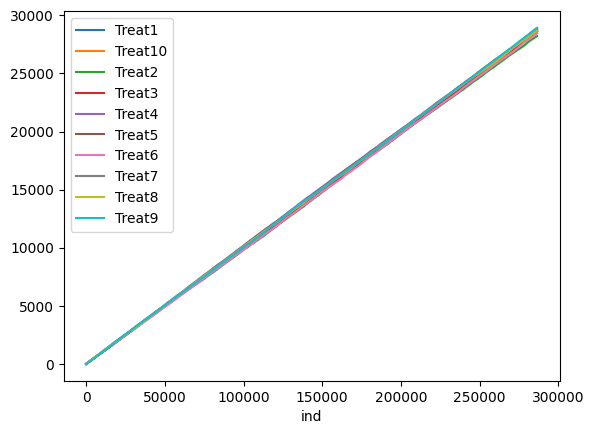

Counter({8: 28913, 4: 28909, 3: 28754, 6: 28750, 7: 28668, 9: 28658, 0: 28641, 2: 28613, 5: 28423, 1: 28206})
[================================================= ] 99%  Progress

7      151.94
3      172.58
4      169.53
8      132.07
5      153.39
9      114.72
2      176.15
6      134.31
1    17720.56
0     8383.85
dtype: float64


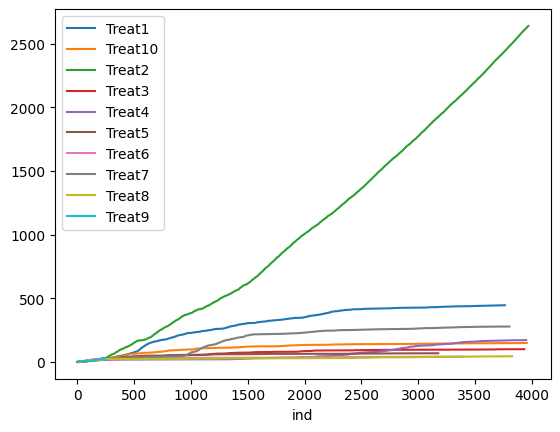

Counter({1: 2638, 0: 446, 6: 279, 3: 173, 9: 150, 2: 101, 4: 69, 7: 45, 5: 42, 8: 28})
[================================================= ] 99%  Progress

2     162.09
0    9084.65
5     179.31
8     144.14
6     138.22
3     188.59
9     114.44
1    9307.26
4     166.18
7     154.40
dtype: float64


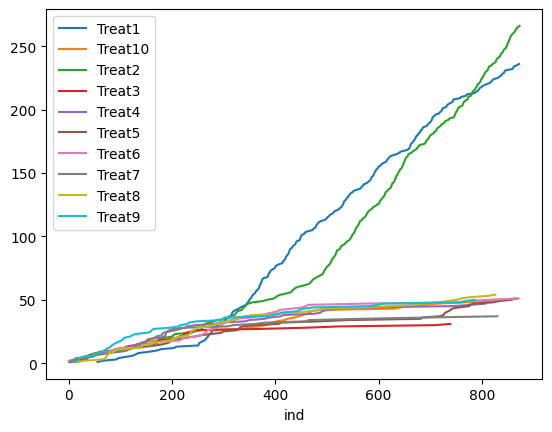

Counter({1: 266, 0: 236, 7: 54, 5: 51, 4: 51, 9: 51, 8: 50, 3: 47, 6: 37, 2: 31})


In [ ]:
## Run the experiment for all three different sets of data
UR_res = []
TS_res = []
TTTS_res = []

for i in range(len(data_means)):
  UR_res.append(run_experiment(alg="UR", B=100, conf_levels=[0.9, 0.95, 0.99],
                               true_means=data_means[i],
                               true_best_arm_ind=true_bais[i], sample_ind=1))
  TS_res.append(run_experiment(alg="TS", B=100, conf_levels=[0.9, 0.95, 0.99],
                               true_means=data_means[i],
                               true_best_arm_ind=true_bais[i], sample_ind=1))
  TTTS_res.append(run_experiment(alg="TTTS", B=100, conf_levels=[0.9, 0.95, 0.99],
                                 true_means=data_means[i],
                                 true_best_arm_ind=true_bais[i], sample_ind=1))

### Result 1: Accuracy (Correct Best-Arm Identification)

In [ ]:
all_res = [UR_res, TS_res, TTTS_res]
alg_names = ["UR", "TS", "TTTS"]
data_types = ["Clear Winner", "No Clear Winner", "Competing Second Best"]

for i in range(len(all_res)):
  for j in range(len(all_res[i])):
    print("Accuracy of the ", alg_names[i], " in ", data_types[j], " = ", all_res[i][j].mean()[3])

Accuracy of the  UR  in  Clear Winner  =  0.99
Accuracy of the  UR  in  No Clear Winner  =  0.92
Accuracy of the  UR  in  Competing Second Best  =  0.82
Accuracy of the  TS  in  Clear Winner  =  1.0
Accuracy of the  TS  in  No Clear Winner  =  0.99
Accuracy of the  TS  in  Competing Second Best  =  0.92
Accuracy of the  TTTS  in  Clear Winner  =  1.0
Accuracy of the  TTTS  in  No Clear Winner  =  1.0
Accuracy of the  TTTS  in  Competing Second Best  =  0.92


### Result 2: Number of Measurements Required to Reach Given Confidence Level

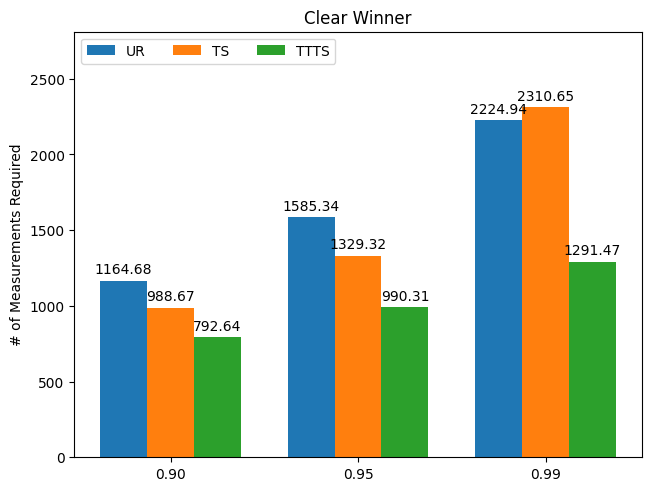

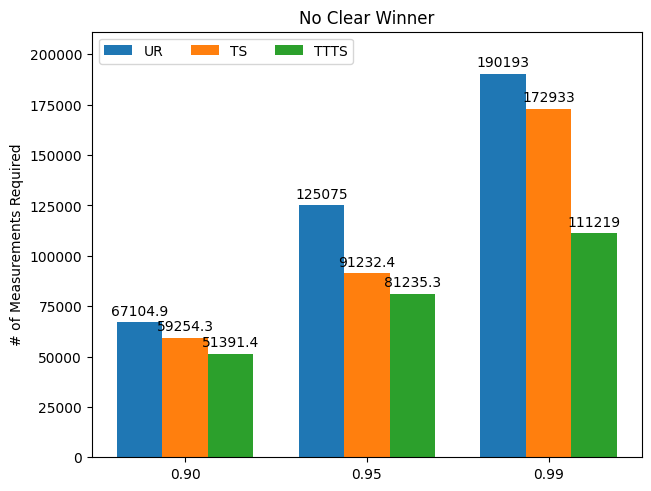

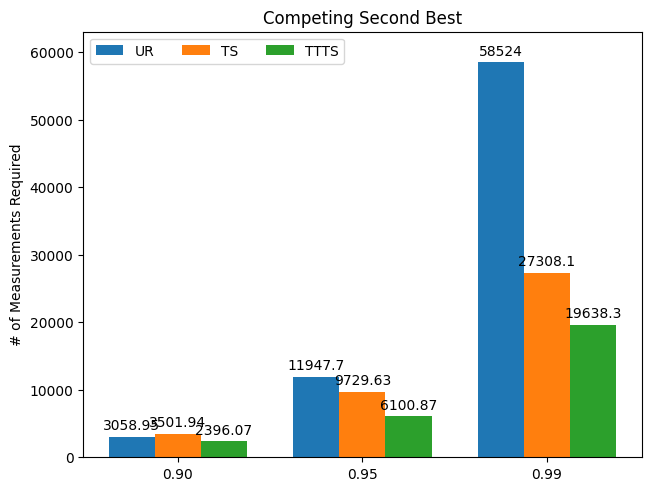

In [ ]:
## Plot the results on the sample size required for a given confidence level
from collections import defaultdict

data_types = ["Clear Winner", "No Clear Winner", "Competing Second Best"]
conf_levels = ("0.90", "0.95", "0.99")
y_lim_vals = [500, 21000, 4500]

for i in range(len(data_types)):
  figure_temp_dict = defaultdict(list)
  combined_res = [UR_res[i], TS_res[i], TTTS_res[i]]
  for j in range(len(alg_names)):
    for k in range(len(combined_res[j].mean())-1):
      figure_temp_dict[alg_names[j]].append(combined_res[j].mean()[k])
  x = np.arange(len(conf_levels))
  width = 0.25
  multiplier = 0
  fig, ax = plt.subplots(layout='constrained')
  for alg, measurement in figure_temp_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=alg)
    ax.bar_label(rects, padding=3)
    multiplier += 1
  # Add labels, title, custom x-axis tick labels.
  ax.set_ylabel('# of Measurements Required')
  ax.set_title(data_types[i])
  ax.set_xticks(x + width, conf_levels)
  ax.legend(loc='upper left', ncols=3)
  y_lim_var = max(u for v in figure_temp_dict.values() for u in v) + y_lim_vals[i]
  ax.set_ylim(0, y_lim_var)
  plt.show()